In [420]:
import re
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import bigrams
from nltk.classify import apply_features

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics

from collections import Counter

sns.set(style='whitegrid', color_codes=True)

### Part I: Blog Data Setup and Profiling

In [2]:
female_test_filepath = os.path.expanduser('~/Downloads/blog_data/female_test.txt')
male_test_filepath = os.path.expanduser('~/Downloads/blog_data/male_test.txt')
female_training_filepath = os.path.expanduser('~/Downloads/blog_data/female_training.txt')
male_training_filepath = os.path.expanduser('~/Downloads/blog_data/male_training.txt')

with open(female_test_filepath) as f:
    female_test_raw = f.read()

with open(male_test_filepath) as f:
    male_test_raw = f.read()

with open(female_training_filepath) as f:
    female_training_raw = f.read()

with open(male_training_filepath) as f:
    male_training_raw = f.read()

**Step 1**: Using Python string formatting and regular expressions, strip off the POS tags so that
you have POS and NOPOS versions of the training and test datasets. Create unigram and
bigram versions of the datasets.

In [3]:
print(type(female_test_raw))
female_test_raw[:10]

<class 'str'>


"I/PRP '/''"

Split at new lines to separate the blog posts from each other. This transforms the dataset into a list of strings; each string represents a blog post.

In [4]:
female_test = female_test_raw.split('\n')
male_test = male_test_raw.split('\n')
female_training = female_training_raw.split('\n')
male_training = male_training_raw.split('\n')

Remove empty blog posts created by the split.

In [5]:
female_test = list(filter(None, female_test))
male_test = list(filter(None, male_test))
female_training = list(filter(None, female_training))
male_training = list(filter(None, male_training))

In [6]:
print('Number of female blog posts (test dataset):', len(female_test))
print('Number of male blog posts (test dataset):', len(male_test))
print('Number of female blog posts (training dataset):', len(female_training))
print('Number of male blog posts (training dataset):', len(male_training))

Number of female blog posts (test dataset): 25001
Number of male blog posts (test dataset): 25000
Number of female blog posts (training dataset): 50000
Number of male blog posts (training dataset): 50000


In [7]:
print(type(female_test[0]))
female_test[0]

<class 'str'>


"I/PRP '/'' ve/FW been/VBN had/VBN by/IN a/DT burrito/NN !/. This/DT past/JJ Saturday/NNP night/NN I/PRP was/VBD soooo/JJ close/NN to/TO snagging/VBG Mr./NNP July/NNP ,/, but/CC he/PRP picked/VBD a/DT burrito/NN over/IN me/PRP ./. Basically/RB I/PRP chatted/VBD //CD flirted/VBN with/IN this/DT one/CD guy/NN the/DT entire/JJ night/NN and/CC at/IN 2:00/CD am/VBP he/PRP says/VBZ he/PRP is/VBZ going/VBG to/TO grab/VB a/DT burrito/NN ./. Our/PRP$ flirtation/NN was/VBD mutual/JJ so/IN I/PRP was/VBD a/DT little/JJ confused/JJ by/IN the/DT burrito/NN ./. I/PRP think/VBP to/TO combat/VB this/DT problem/NN in/IN the/DT future/NN I/PRP am/VBP going/VBG to/TO carry/VB frozen/JJ burrito/NN 's/POS with/IN me/PRP ./. This/DT way/NN the/DT guy/NN has/VBZ no/DT excuse/NN to/TO get/VB away/RB ./. Just/RB four/CD more/JJR days/NNS left/VBN in/IN July/NNP ./. I/PRP am/VBP getting/VBG a/DT little/JJ nervous/JJ .../:"

Tokenise the blog posts at whitespaces before stripping POS tags using a regular expression (`\S` matches any non-whitespace character). This transforms each blog post into a list of strings.

In [8]:
female_test_pos = [post.split(' ') for post in female_test]
male_test_pos = [post.split(' ') for post in male_test]
female_training_pos = [post.split(' ') for post in female_training]
male_training_pos = [post.split(' ') for post in male_training]

In [9]:
print(female_test_pos[0])

['I/PRP', "'/''", 've/FW', 'been/VBN', 'had/VBN', 'by/IN', 'a/DT', 'burrito/NN', '!/.', 'This/DT', 'past/JJ', 'Saturday/NNP', 'night/NN', 'I/PRP', 'was/VBD', 'soooo/JJ', 'close/NN', 'to/TO', 'snagging/VBG', 'Mr./NNP', 'July/NNP', ',/,', 'but/CC', 'he/PRP', 'picked/VBD', 'a/DT', 'burrito/NN', 'over/IN', 'me/PRP', './.', 'Basically/RB', 'I/PRP', 'chatted/VBD', '//CD', 'flirted/VBN', 'with/IN', 'this/DT', 'one/CD', 'guy/NN', 'the/DT', 'entire/JJ', 'night/NN', 'and/CC', 'at/IN', '2:00/CD', 'am/VBP', 'he/PRP', 'says/VBZ', 'he/PRP', 'is/VBZ', 'going/VBG', 'to/TO', 'grab/VB', 'a/DT', 'burrito/NN', './.', 'Our/PRP$', 'flirtation/NN', 'was/VBD', 'mutual/JJ', 'so/IN', 'I/PRP', 'was/VBD', 'a/DT', 'little/JJ', 'confused/JJ', 'by/IN', 'the/DT', 'burrito/NN', './.', 'I/PRP', 'think/VBP', 'to/TO', 'combat/VB', 'this/DT', 'problem/NN', 'in/IN', 'the/DT', 'future/NN', 'I/PRP', 'am/VBP', 'going/VBG', 'to/TO', 'carry/VB', 'frozen/JJ', 'burrito/NN', "'s/POS", 'with/IN', 'me/PRP', './.', 'This/DT', 'way/NN

In [10]:
female_test_nopos = [[re.sub(r"/\S+", "", word) for word in post] for post in female_test_pos]
male_test_nopos = [[re.sub(r"/\S+", "", word) for word in post] for post in male_test_pos]
female_training_nopos = [[re.sub(r"/\S+", "", word) for word in post] for post in female_training_pos]
male_training_nopos = [[re.sub(r"/\S+", "", word) for word in post] for post in male_training_pos]

In [11]:
print(female_test_nopos[0])

['I', "'", 've', 'been', 'had', 'by', 'a', 'burrito', '!', 'This', 'past', 'Saturday', 'night', 'I', 'was', 'soooo', 'close', 'to', 'snagging', 'Mr.', 'July', ',', 'but', 'he', 'picked', 'a', 'burrito', 'over', 'me', '.', 'Basically', 'I', 'chatted', '', 'flirted', 'with', 'this', 'one', 'guy', 'the', 'entire', 'night', 'and', 'at', '2:00', 'am', 'he', 'says', 'he', 'is', 'going', 'to', 'grab', 'a', 'burrito', '.', 'Our', 'flirtation', 'was', 'mutual', 'so', 'I', 'was', 'a', 'little', 'confused', 'by', 'the', 'burrito', '.', 'I', 'think', 'to', 'combat', 'this', 'problem', 'in', 'the', 'future', 'I', 'am', 'going', 'to', 'carry', 'frozen', 'burrito', "'s", 'with', 'me', '.', 'This', 'way', 'the', 'guy', 'has', 'no', 'excuse', 'to', 'get', 'away', '.', 'Just', 'four', 'more', 'days', 'left', 'in', 'July', '.', 'I', 'am', 'getting', 'a', 'little', 'nervous', '...']


Create bigram versions of the POS-stripped datasets.

In [12]:
female_test_bigrams = [list(bigrams(post)) for post in female_test_nopos]
male_test_bigrams = [list(bigrams(post)) for post in male_test_nopos]
female_training_bigrams = [list(bigrams(post)) for post in female_training_nopos]
male_training_bigrams = [list(bigrams(post)) for post in male_training_nopos]

In [13]:
print(female_test_bigrams[0])

[('I', "'"), ("'", 've'), ('ve', 'been'), ('been', 'had'), ('had', 'by'), ('by', 'a'), ('a', 'burrito'), ('burrito', '!'), ('!', 'This'), ('This', 'past'), ('past', 'Saturday'), ('Saturday', 'night'), ('night', 'I'), ('I', 'was'), ('was', 'soooo'), ('soooo', 'close'), ('close', 'to'), ('to', 'snagging'), ('snagging', 'Mr.'), ('Mr.', 'July'), ('July', ','), (',', 'but'), ('but', 'he'), ('he', 'picked'), ('picked', 'a'), ('a', 'burrito'), ('burrito', 'over'), ('over', 'me'), ('me', '.'), ('.', 'Basically'), ('Basically', 'I'), ('I', 'chatted'), ('chatted', ''), ('', 'flirted'), ('flirted', 'with'), ('with', 'this'), ('this', 'one'), ('one', 'guy'), ('guy', 'the'), ('the', 'entire'), ('entire', 'night'), ('night', 'and'), ('and', 'at'), ('at', '2:00'), ('2:00', 'am'), ('am', 'he'), ('he', 'says'), ('says', 'he'), ('he', 'is'), ('is', 'going'), ('going', 'to'), ('to', 'grab'), ('grab', 'a'), ('a', 'burrito'), ('burrito', '.'), ('.', 'Our'), ('Our', 'flirtation'), ('flirtation', 'was'), ('w

Associate all of the datasets with their labels (male or female) by generating lists of tuples.

In [14]:
female_test_pos_labelled = [(post, 'female') for post in female_test_pos]
male_test_pos_labelled = [(post, 'male') for post in male_test_pos]
female_training_pos_labelled = [(post, 'female') for post in female_training_pos]
male_training_pos_labelled = [(post, 'male') for post in male_training_pos]

In [15]:
female_test_nopos_labelled = [(post, 'female') for post in female_test_nopos]
male_test_nopos_labelled = [(post, 'male') for post in male_test_nopos]
female_training_nopos_labelled = [(post, 'female') for post in female_training_nopos]
male_training_nopos_labelled = [(post, 'male') for post in male_training_nopos]

In [284]:
female_test_bigrams_labelled = [(post, 'female') for post in female_test_bigrams]
male_test_bigrams_labelled = [(post, 'male') for post in male_test_bigrams]
female_training_bigrams_labelled = [(post, 'female') for post in female_training_bigrams]
male_training_bigrams_labelled = [(post, 'male') for post in male_training_bigrams]

In [17]:
print(female_test_pos_labelled[0])

(['I/PRP', "'/''", 've/FW', 'been/VBN', 'had/VBN', 'by/IN', 'a/DT', 'burrito/NN', '!/.', 'This/DT', 'past/JJ', 'Saturday/NNP', 'night/NN', 'I/PRP', 'was/VBD', 'soooo/JJ', 'close/NN', 'to/TO', 'snagging/VBG', 'Mr./NNP', 'July/NNP', ',/,', 'but/CC', 'he/PRP', 'picked/VBD', 'a/DT', 'burrito/NN', 'over/IN', 'me/PRP', './.', 'Basically/RB', 'I/PRP', 'chatted/VBD', '//CD', 'flirted/VBN', 'with/IN', 'this/DT', 'one/CD', 'guy/NN', 'the/DT', 'entire/JJ', 'night/NN', 'and/CC', 'at/IN', '2:00/CD', 'am/VBP', 'he/PRP', 'says/VBZ', 'he/PRP', 'is/VBZ', 'going/VBG', 'to/TO', 'grab/VB', 'a/DT', 'burrito/NN', './.', 'Our/PRP$', 'flirtation/NN', 'was/VBD', 'mutual/JJ', 'so/IN', 'I/PRP', 'was/VBD', 'a/DT', 'little/JJ', 'confused/JJ', 'by/IN', 'the/DT', 'burrito/NN', './.', 'I/PRP', 'think/VBP', 'to/TO', 'combat/VB', 'this/DT', 'problem/NN', 'in/IN', 'the/DT', 'future/NN', 'I/PRP', 'am/VBP', 'going/VBG', 'to/TO', 'carry/VB', 'frozen/JJ', 'burrito/NN', "'s/POS", 'with/IN', 'me/PRP', './.', 'This/DT', 'way/N

In [18]:
print(female_test_nopos_labelled[0])

(['I', "'", 've', 'been', 'had', 'by', 'a', 'burrito', '!', 'This', 'past', 'Saturday', 'night', 'I', 'was', 'soooo', 'close', 'to', 'snagging', 'Mr.', 'July', ',', 'but', 'he', 'picked', 'a', 'burrito', 'over', 'me', '.', 'Basically', 'I', 'chatted', '', 'flirted', 'with', 'this', 'one', 'guy', 'the', 'entire', 'night', 'and', 'at', '2:00', 'am', 'he', 'says', 'he', 'is', 'going', 'to', 'grab', 'a', 'burrito', '.', 'Our', 'flirtation', 'was', 'mutual', 'so', 'I', 'was', 'a', 'little', 'confused', 'by', 'the', 'burrito', '.', 'I', 'think', 'to', 'combat', 'this', 'problem', 'in', 'the', 'future', 'I', 'am', 'going', 'to', 'carry', 'frozen', 'burrito', "'s", 'with', 'me', '.', 'This', 'way', 'the', 'guy', 'has', 'no', 'excuse', 'to', 'get', 'away', '.', 'Just', 'four', 'more', 'days', 'left', 'in', 'July', '.', 'I', 'am', 'getting', 'a', 'little', 'nervous', '...'], 'female')


In [19]:
print(female_test_bigrams_labelled[0])

([('I', "'"), ("'", 've'), ('ve', 'been'), ('been', 'had'), ('had', 'by'), ('by', 'a'), ('a', 'burrito'), ('burrito', '!'), ('!', 'This'), ('This', 'past'), ('past', 'Saturday'), ('Saturday', 'night'), ('night', 'I'), ('I', 'was'), ('was', 'soooo'), ('soooo', 'close'), ('close', 'to'), ('to', 'snagging'), ('snagging', 'Mr.'), ('Mr.', 'July'), ('July', ','), (',', 'but'), ('but', 'he'), ('he', 'picked'), ('picked', 'a'), ('a', 'burrito'), ('burrito', 'over'), ('over', 'me'), ('me', '.'), ('.', 'Basically'), ('Basically', 'I'), ('I', 'chatted'), ('chatted', ''), ('', 'flirted'), ('flirted', 'with'), ('with', 'this'), ('this', 'one'), ('one', 'guy'), ('guy', 'the'), ('the', 'entire'), ('entire', 'night'), ('night', 'and'), ('and', 'at'), ('at', '2:00'), ('2:00', 'am'), ('am', 'he'), ('he', 'says'), ('says', 'he'), ('he', 'is'), ('is', 'going'), ('going', 'to'), ('to', 'grab'), ('grab', 'a'), ('a', 'burrito'), ('burrito', '.'), ('.', 'Our'), ('Our', 'flirtation'), ('flirtation', 'was'), ('

**Step 2**: Combine the labelled test sets into one data structure.

In [20]:
test_pos_labelled = female_test_pos_labelled + male_test_pos_labelled
test_nopos_labelled = female_test_nopos_labelled + male_test_nopos_labelled
test_bigrams_labelled = female_test_bigrams_labelled + male_test_bigrams_labelled

In [21]:
print(len(test_pos_labelled))
print(len(test_nopos_labelled))
print(len(test_bigrams_labelled))

50001
50001
50001


**Step 3**: Establish a) the vocabulary of each unigram dataset (its unique words) and b) the
count of each vocabulary item in each dataset. Note that there are six datasets: female training
data with/without POS, male training data with/without POS, and test data with/without POS.

Currently each dataset is represented as a list of lists (each sublist contains the words in a given blog post). We can use the `set` function to obtain the vocabulary of each dataset, and Python's `Counter` subclass to obtain the count of each vocabulary item. To apply these, we first need to flatten the lists in each dataset into one list that contains all of the words in all of the posts.

In [22]:
female_training_pos_wordlist = [word for post in female_training_pos for word in post]
female_training_nopos_wordlist = [word for post in female_training_nopos for word in post]
male_training_pos_wordlist = [word for post in male_training_pos for word in post]
male_training_nopos_wordlist = [word for post in male_training_nopos for word in post]

To create the wordlists for the labelled test datasets, we need to access the first item in the tuple.

In [23]:
test_pos_unlabelled = [x[0] for x in test_pos_labelled]
test_nopos_unlabelled = [x[0] for x in test_nopos_labelled]
test_pos_wordlist = [word for post in test_pos_unlabelled for word in post]
test_nopos_wordlist = [word for post in test_nopos_unlabelled for word in post]

In [24]:
female_training_pos_vocab = set(female_training_pos_wordlist)
female_training_nopos_vocab = set(female_training_nopos_wordlist)
male_training_pos_vocab = set(male_training_pos_wordlist)
male_training_nopos_vocab = set(male_training_nopos_wordlist)
test_pos_vocab = set(test_pos_wordlist)
test_nopos_vocab = set(test_nopos_wordlist)

In [25]:
print('Number of unique words in the female training POS corpus:', len(female_training_pos_vocab))
print('Number of unique words in the female training NOPOS corpus:', len(female_training_nopos_vocab))
print('Number of unique words in the male training POS corpus:', len(male_training_pos_vocab))
print('Number of unique words in the male training NOPOS corpus:', len(male_training_nopos_vocab))
print('Number of unique words in the test POS corpus:', len(test_pos_vocab))
print('Number of unique words in the test NOPOS corpus:', len(test_nopos_vocab))

Number of unique words in the female training POS corpus: 285033
Number of unique words in the female training NOPOS corpus: 226638
Number of unique words in the male training POS corpus: 307639
Number of unique words in the male training NOPOS corpus: 250297
Number of unique words in the test POS corpus: 301847
Number of unique words in the test NOPOS corpus: 243197


In [26]:
female_training_pos_counts = Counter(female_training_pos_wordlist)
female_training_nopos_counts = Counter(female_training_nopos_wordlist)
male_training_pos_counts = Counter(male_training_pos_wordlist)
male_training_nopos_counts = Counter(male_training_nopos_wordlist)
test_pos_counts = Counter(test_pos_wordlist)
test_nopos_counts = Counter(test_nopos_wordlist)

**QUESTION 1**: Generate Zipfian plots of rank-frequency distributions for the unigram
vocabularies from the female training data with/without POS, the male training data
with/without POS, and the test data with/without POS. You can superimpose the two female
plots, the two male plots, and the two test data plots. Use a log-log scale. Comment on the
general shape of the plots and the differences between the different files. Make a prediction
about what Zipfian rank-frequency distributions of the bigrams would look like.

In [27]:
print('Most common unigrams in the female training POS corpus:', female_training_pos_counts.most_common(10))
print('Most common unigrams in the female training NOPOS corpus:', female_training_nopos_counts.most_common(10))
print('Most common unigrams in the male training POS corpus:', male_training_pos_counts.most_common(10))
print('Most common unigrams in the male training NOPOS corpus:', male_training_nopos_counts.most_common(10))
print('Most common unigrams in the test POS corpus:', test_pos_counts.most_common(10))
print('Most common unigrams in the test NOPOS corpus:', test_nopos_counts.most_common(10))

Most common unigrams in the female training POS corpus: [('./.', 679573), (',/,', 505670), ('the/DT', 424090), ('I/PRP', 414755), ('to/TO', 336753), ('and/CC', 299525), ('a/DT', 248984), ('of/IN', 208042), ('in/IN', 150978), ('it/PRP', 136479)]
Most common unigrams in the female training NOPOS corpus: [('.', 679573), (',', 505670), ('the', 424093), ('I', 415194), ('to', 336753), ('and', 299525), ('a', 249527), ('of', 208043), ('in', 151759), ('that', 139436)]
Most common unigrams in the male training POS corpus: [('./.', 642756), (',/,', 511537), ('the/DT', 486972), ('to/TO', 308301), ('I/PRP', 269634), ('and/CC', 269025), ('a/DT', 248847), ('of/IN', 243724), ('in/IN', 161306), ('is/VBZ', 131063)]
Most common unigrams in the male training NOPOS corpus: [('.', 642756), (',', 511537), ('the', 486977), ('to', 308301), ('I', 269966), ('and', 269026), ('a', 249381), ('of', 243724), ('in', 162090), ('that', 134292)]
Most common unigrams in the test POS corpus: [('./.', 658115), (',/,', 50735

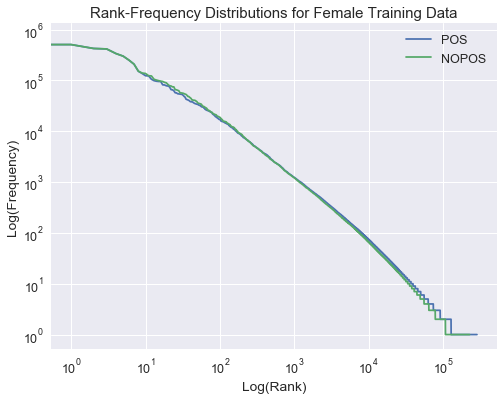

In [56]:
sns.set(font_scale=1.25)
plt.figure(figsize=(8,6))
plt.loglog(range(len(female_training_pos_counts)), sorted(female_training_pos_counts.values(), reverse=True), label='POS')
plt.loglog(range(len(female_training_nopos_counts)), sorted(female_training_nopos_counts.values(), reverse=True), label='NOPOS')
plt.title('Rank-Frequency Distributions for Female Training Data')
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Frequency)')
plt.legend()
plt.show()

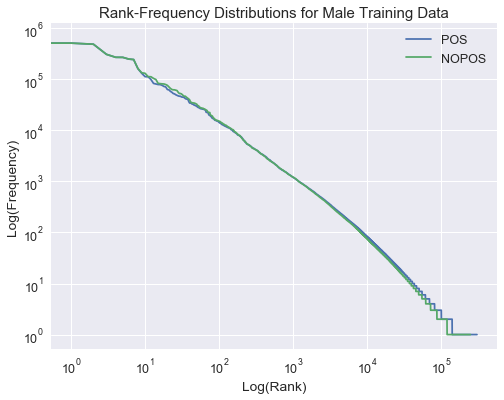

In [58]:
plt.figure(figsize=(8,6))
plt.loglog(range(len(male_training_pos_counts)), sorted(male_training_pos_counts.values(), reverse=True), label='POS')
plt.loglog(range(len(male_training_nopos_counts)), sorted(male_training_nopos_counts.values(), reverse=True), label='NOPOS')
plt.title('Rank-Frequency Distributions for Male Training Data')
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Frequency)')
plt.legend()
plt.show()

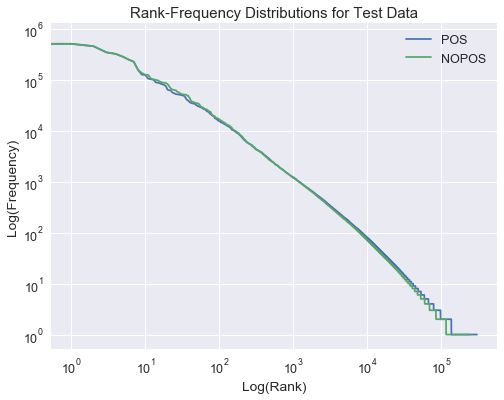

In [59]:
plt.figure(figsize=(8,6))
plt.loglog(range(len(test_pos_counts)), sorted(test_pos_counts.values(), reverse=True), label='POS')
plt.loglog(range(len(test_nopos_counts)), sorted(test_nopos_counts.values(), reverse=True), label='NOPOS')
plt.title('Rank-Frequency Distributions for Test Data')
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Frequency)')
plt.legend()
plt.show()

All three distributions look extremely similar, and there is hardly any difference between the POS and NOPOS curves, which demonstrates that we are not getting a lot more information from the POS tags (the only noticeable difference is that there is a sharper drop in frequency for the NOPOS curves for low-frequency words). The distributions are concave down at both ends and straighter in the middle. Unigrams with and without POS thus follow a power law; there is a heavier tail of words that only occur once. This conforms with rank-frequency distributions for text data in general.

**QUESTION 2**: Now we want to know how much the vocabularies of different pairs of files
overlap. Generate a 3 by 3 table for the unigram POS vocabularies with both rows and
columns labelled {FEMALE-TRAINING, MALE-TRAINING, TEST}. In each cell X_ij put the count
of unigram POS labels occurring in file X_i that also occur in file X_j. Of course the diagonal
X_ii for the table will be the total count of words in X_i. The table will be symmetric around
the diagonal. Make the same 3 by 3 table for the unigram NOPOS vocabularies. Study the
numbers in the tables. How many words appear in training data for one gender but not the
other? How many appear in test data but not training data? Comment on the rate of out-ofvocabulary
(OOV) forms in test data if you have trained on male vs female blog data.

In [80]:
pos_vocab = [female_training_pos_vocab, male_training_pos_vocab, test_pos_vocab]
pos_vocab_array = np.empty([len(pos_vocab),len(pos_vocab)])

for i in range(len(pos_vocab)):
    for j in range(len(pos_vocab)):
        pos_vocab_array[i][j] = len(pos_vocab[i].intersection(pos_vocab[j]))

pos_vocab_df = pd.DataFrame(pos_vocab_array.astype(int), columns=['FEMALE TRAINING', 'MALE TRAINING', 'TEST'])
pos_vocab_df.rename(index={0: 'FEMALE TRAINING', 1: 'MALE TRAINING', 2: 'TEST'}, inplace=True)
pos_vocab_df

,FEMALE TRAINING,MALE TRAINING,TEST
FEMALE TRAINING,285033,132123,139897
MALE TRAINING,132123,307639,146892
TEST,139897,146892,301847


In [81]:
nopos_vocab = [female_training_nopos_vocab, male_training_nopos_vocab, test_nopos_vocab]
nopos_vocab_array = np.zeros([len(nopos_vocab),len(nopos_vocab)])

for i in range(len(nopos_vocab)):
    for j in range(len(nopos_vocab)):
        nopos_vocab_array[i][j] = len(nopos_vocab[i].intersection(nopos_vocab[j]))
        
nopos_vocab_df = pd.DataFrame(nopos_vocab_array.astype(int), columns=['FEMALE TRAINING', 'MALE TRAINING', 'TEST'])
nopos_vocab_df.rename(index={0: 'FEMALE TRAINING', 1: 'MALE TRAINING', 2: 'TEST'}, inplace=True)
nopos_vocab_df

,FEMALE TRAINING,MALE TRAINING,TEST
FEMALE TRAINING,226638,108812,114983
MALE TRAINING,108812,250297,122099
TEST,114983,122099,243197


There is a large difference in vocabulary for the two genders: only 132,123 unigrams with POS tags occur in blogs written by both genders. Given the vocabulary size of male and female blog posts, this means that 152,910 words occur in the female training dataset but not in the male training dataset, and 175,516 words occur in the male training dataset but not the female training dataset. 108,812 unigrams without POS tags occur in blogs written by both genders. 117,826 occur in the female training dataset but not in the male training dataset, and 141,485 occur in the male training dataset but not the female training dataset.

The number of OOV forms is also enormous. For the unigram POS dataset, 161,950 words occur in test data but not in the female training data; 154,955 words occur in test data but not in the male training data. For the unigram NOPOS dataset, 128,214 words occur in test data but not in the female training data; 121,098 words occur in test data but not in the male training data. Thus, in both cases, the rate of OOV forms in test data is greater if you have trained on female data as opposed to male data. The difference is ~7,000 words for both datasets (it is slightly higher for the NOPOS dataset).

### Part II: Naïve Bayes Gender Classification

In [285]:
training_nopos_labelled = female_training_nopos_labelled + male_training_nopos_labelled
training_pos_labelled = female_training_pos_labelled + male_training_pos_labelled
training_bigrams_labelled = female_training_bigrams_labelled + male_training_bigrams_labelled

In [121]:
nopos_training_set = [(dict(Counter(post)), gender) for (post, gender) in training_nopos_labelled]
nopos_test_set = [(dict(Counter(post)), gender) for (post, gender) in test_nopos_labelled]

In [84]:
pos_training_set = [(dict(Counter(post)), gender) for (post, gender) in training_pos_labelled]
pos_test_set = [(dict(Counter(post)), gender) for (post, gender) in test_pos_labelled]

In [286]:
bigrams_training_set = [(dict(Counter(post)), gender) for (post, gender) in training_bigrams_labelled]
bigrams_test_set = [(dict(Counter(post)), gender) for (post, gender) in test_bigrams_labelled]

In [91]:
print(pos_training_set[2])

({'much/RB': 1, "haven't/VBP": 1, 'contact/NN': 1, 'everything/NN': 1, 'doing/VBG': 1, 'is/VBZ': 2, ')/NN': 1, 'weekend/NN': 1, 'bring/VB': 1, 'a/DT': 1, 'going/VBG': 1, './.': 8, 'to/TO': 2, 'efficient/JJ': 1, 'asked/VBN': 1, 'have/VBP': 2, 'grapevine/NN': 1, 'I/PRP': 8, 'information/NN': 1, 'email/NN': 1, 'find/VB': 1, 'am/VBP': 3, 'finally/RB': 1, 'that/DT': 1, 'old/JJ': 1, 'holiday/NN': 1, 'June/NNP': 1, 'in/IN': 1, 'yet/RB': 1, 'Mr./NNP': 2, 'Look/VB': 1, 'next/JJ': 1, 'post/VB': 1, 'emails/NNS': 1, 'will/MD': 1, 'so/RB': 2, 'picture/NN': 1, 'ladies/NNS': 1, 'than/IN': 1, 'been/VBN': 1, 'prospects/NNS': 1, 'chain/NN': 1, 'enjoy/VBP': 1, 'see/VBP': 1, 'has/VBZ': 1, 'out/RP': 1, 'just/RB': 1, 'me/PRP': 1, 'for/IN': 3, 'Through/IN': 1, 'so/IN': 1, 'although/IN': 1, 'July/NNP': 2, 'easier/JJR': 1, 'also/RB': 1, 'look/VB': 1, 'place/NN': 1, 'found/VBD': 1, 'put/VBN': 1, 'him/PRP': 1, 'some/DT': 1, 'an/DT': 1, 'it/PRP': 2, '(/CD': 1, 'up/RP': 1, 'blog/NN': 1, 'way/NN': 1, 'around/IN': 1

In [88]:
print(pos_test_set[0])

({'frozen/JJ': 1, 'picked/VBD': 1, 'is/VBZ': 1, 'a/DT': 5, 'going/VBG': 2, 'by/IN': 2, 'left/VBN': 1, 'to/TO': 5, 'no/DT': 1, 'I/PRP': 7, 'snagging/VBG': 1, 'am/VBP': 3, 'but/CC': 1, 'excuse/NN': 1, 'soooo/JJ': 1, 'in/IN': 2, 'think/VBP': 1, 'Mr./NNP': 1, 'Saturday/NNP': 1, 'flirted/VBN': 1, 'with/IN': 2, 'getting/VBG': 1, 'been/VBN': 1, 'had/VBN': 1, 'Just/RB': 1, 'problem/NN': 1, '2:00/CD': 1, 'has/VBZ': 1, 'and/CC': 1, 've/FW': 1, '!/.': 1, 'me/PRP': 2, 'at/IN': 1, 'combat/VB': 1, 'get/VB': 1, 'so/IN': 1, '//CD': 1, 'July/NNP': 2, 'more/JJR': 1, 'nervous/JJ': 1, 'Basically/RB': 1, 'This/DT': 2, 'guy/NN': 2, 'little/JJ': 2, 'entire/JJ': 1, 'he/PRP': 3, '.../:': 1, "'/''": 1, './.': 6, 'Our/PRP$': 1, 'way/NN': 1, 'flirtation/NN': 1, 'confused/JJ': 1, 'mutual/JJ': 1, 'past/JJ': 1, 'was/VBD': 3, 'says/VBZ': 1, 'this/DT': 2, 'grab/VB': 1, 'future/NN': 1, "'s/POS": 1, 'close/NN': 1, 'over/IN': 1, 'the/DT': 4, 'four/CD': 1, 'chatted/VBD': 1, 'days/NNS': 1, 'burrito/NN': 5, 'one/CD': 1, 'ca

**Step 1**: Based upon your work for the previous question, determine the out of vocabulary (OOV) items—i.e., the words in the combined test dataset that are not in the male training dataset, and the words in the combined test dataset that are not in the female training dataset.

In [287]:
female_training_bigrams_wordlist = [bigram for post in female_training_bigrams for bigram in post]
male_training_bigrams_wordlist = [bigram for post in male_training_bigrams for bigram in post]
test_bigrams_unlabelled = [x[0] for x in test_bigrams_labelled]
test_bigrams_wordlist = [bigram for post in test_bigrams_unlabelled for bigram in post]
female_training_bigrams_vocab = set(female_training_bigrams_wordlist)
male_training_bigrams_vocab = set(male_training_bigrams_wordlist)
test_bigrams_vocab = set(test_bigrams_wordlist)

In [288]:
oov_male_nopos = test_nopos_vocab - male_training_nopos_vocab.intersection(test_nopos_vocab)
oov_female_nopos = test_nopos_vocab - female_training_nopos_vocab.intersection(test_nopos_vocab)
oov_male_pos = test_pos_vocab - male_training_pos_vocab.intersection(test_pos_vocab)
oov_female_pos = test_pos_vocab - female_training_pos_vocab.intersection(test_pos_vocab)
oov_male_bigrams = test_bigrams_vocab - male_training_bigrams_vocab.intersection(test_bigrams_vocab)
oov_female_bigrams = test_bigrams_vocab - female_training_bigrams_vocab.intersection(test_bigrams_vocab)

In [289]:
print(list(oov_male_nopos)[:10])
print(list(oov_female_nopos)[:10])
print(list(oov_male_pos)[:10])
print(list(oov_female_pos)[:10])
print(list(oov_male_bigrams)[:10])
print(list(oov_female_bigrams)[:10])

['rraaahhh', 'Isobutane', 'thpersonaly', 'MDS', 'SMUGames', 'mentorsmothersorfatherscould', 'dilbertblog', 'Americal', 'ennoble', 'travler']
['rraaahhh', 'Isobutane', 'thpersonaly', 'Caminos', 'SMUGames', 'mentorsmothersorfatherscould', 'dilbertblog', 'submariner', 'ennoble', 'travler']
['originial/JJ', 'readingi/NN', 'dispendioso/NN', 'kathryn/NN', 'Crossan/JJ', 'Goke/NNP', 'ktos/NNS', 'patronesses/NNS', 'habang/JJ', 'egentligen/NN']
['Louie/NN', 'originial/JJ', 'readingi/NN', 'dispendioso/NN', 'Tiddly/NNP', 'Crossan/JJ', 'Goke/NNP', 'patronesses/NNS', 'egentligen/NN', 'nahin/VB']
[('grows', 'indignant'), ('Branch', 'listened'), ('involve', 'racism'), ('as', 'Africare'), ('few', 'nutters'), ('is', 'Heng'), ('Atlanta', 'through'), ('and', 'Kraft'), ('12,000', 'on'), ('station', 'cashier')]
[('grows', 'indignant'), ('Branch', 'listened'), ('involve', 'racism'), ('chocolates', 'at'), ('few', 'nutters'), ('as', 'Africare'), ('is', 'Heng'), ('Atlanta', 'through'), ('and', 'Kraft'), ('12,00

In [290]:
print(len(oov_male_nopos), 'words are in the unigram NOPOS test dataset but not in the male training dataset.')
print(len(oov_female_nopos), 'words are in the unigram NOPOS test dataset but not in the female training dataset.')
print(len(oov_male_pos), 'words are in the unigram POS test dataset but not in the male training dataset.')
print(len(oov_female_pos), 'words are in the unigram POS test dataset but not in the female training dataset.')
print(len(oov_male_bigrams), 'words are in the bigram test dataset but not in the male training dataset.')
print(len(oov_female_bigrams), 'words are in the bigram test dataset but not in the female training dataset.')

121098 words are in the unigram NOPOS test dataset but not in the male training dataset.
128214 words are in the unigram NOPOS test dataset but not in the female training dataset.
154955 words are in the unigram POS test dataset but not in the male training dataset.
161950 words are in the unigram POS test dataset but not in the female training dataset.
1814831 words are in the bigram test dataset but not in the male training dataset.
1858957 words are in the bigram test dataset but not in the female training dataset.


**Step 2**: Apply Basic Good-Turing smoothing to obtain more accurate probabilities for these OOV items. The total probability mass for all of the OOV words can be estimated using the number of hapaxes (words that occurred exactly once) in the training set, N1, and the total number of word tokens N in the training set (the length of the training set in words, counting all repetitions of all words). Specifically, the total probability mass to be allocated to the unseen words is N1/N. 

In [102]:
male_nopos_counts = dict(Counter(male_training_nopos_wordlist))
N1_male_nopos = len([k for k,v in male_nopos_counts.items() if v == 1])
N_male_nopos = len(male_training_nopos_wordlist)
P_0_male_nopos = N1_male_nopos/N_male_nopos

female_nopos_counts = dict(Counter(female_training_nopos_wordlist))
N1_female_nopos = len([k for k,v in female_nopos_counts.items() if v == 1])
N_female_nopos = len(female_training_nopos_wordlist)
P_0_female_nopos = N1_female_nopos/N_female_nopos

In [103]:
male_pos_counts = dict(Counter(male_training_pos_wordlist))
N1_male_pos = len([k for k,v in male_pos_counts.items() if v == 1])
N_male_pos = len(male_training_pos_wordlist)
P_0_male_pos = N1_male_pos/N_male_pos

female_pos_counts = dict(Counter(female_training_pos_wordlist))
N1_female_pos = len([k for k,v in female_pos_counts.items() if v == 1])
N_female_pos = len(female_training_pos_wordlist)
P_0_female_pos = N1_female_pos/N_female_pos

In [291]:
male_bigrams_counts = dict(Counter(male_training_bigrams_wordlist))
N1_male_bigrams = len([k for k,v in male_bigrams_counts.items() if v == 1])
N_male_bigrams = len(male_training_bigrams_wordlist)
P_0_male_bigrams = N1_male_bigrams/N_male_bigrams

female_bigrams_counts = dict(Counter(female_training_bigrams_wordlist))
N1_female_bigrams = len([k for k,v in female_bigrams_counts.items() if v == 1])
N_female_bigrams = len(female_training_bigrams_wordlist)
P_0_female_bigrams = N1_female_bigrams/N_female_bigrams

In [292]:
print(P_0_male_nopos)
print(P_0_female_nopos)
print(P_0_male_pos)
print(P_0_female_pos)
print(P_0_male_bigrams)
print(P_0_female_bigrams)

0.009589192653973224
0.00851507936406104
0.012297584352490164
0.011213416095442453
0.1526845979760774
0.1312854996930317


In [293]:
P_i_male_nopos = P_0_male_nopos/len(oov_male_nopos)
P_i_female_nopos = P_0_female_nopos/len(oov_female_nopos)
P_i_nopos = (P_i_male_nopos+P_i_female_nopos)/2
P_i_male_pos = P_0_male_pos/len(oov_male_pos)
P_i_female_pos = P_0_female_pos/len(oov_female_pos)
P_i_pos = (P_i_male_pos+P_i_female_pos)/2
P_i_male_bigrams = P_0_male_bigrams/len(oov_male_bigrams)
P_i_female_bigrams = P_0_female_bigrams/len(oov_female_bigrams)
P_i_bigrams = (P_i_male_bigrams+P_i_female_bigrams)/2

print(P_i_male_nopos)
print(P_i_female_nopos)
print(P_i_nopos)
print(P_i_male_pos)
print(P_i_female_pos)
print(P_i_pos)
print(P_i_male_bigrams)
print(P_i_female_bigrams)
print(P_i_bigrams)

7.918539244226349e-08
6.641302325846663e-08
7.279920785036507e-08
7.936229455319392e-08
6.923998823984225e-08
7.430114139651809e-08
8.413157918069362e-08
7.06232041370681e-08
7.737739165888086e-08


**Step 3**: We are interested in how well each classifier behaves in relation to the length of the
post. For shorter posts, we expect worse performance—but exactly how much worse? Divide
the blog posts in the test set into 10 equal sized buckets, according to the length of the post.
That is, bucket1 has the 5,000 shortest posts in each test set, while bucket10 has the 5,000
longest posts. Of course some buckets might turn out to have more male than female posts,
or vice versa, but this is information that is not reasonably available as a Bayesian prior, which
should represent a prior belief as opposed to inside information about the test set.

In [252]:
test_nopos_labelled.sort(key=lambda x: len(x[0]))
print(len(test_nopos_labelled))
print('Length of shortest blog post in WORD-NOPOS test set:', len(test_nopos_labelled[0][0]))
print('Length of longest blog post in WORD-NOPOS test set:', len(test_nopos_labelled[-1][0]))

50001
Length of shortest blog post in WORD-NOPOS test set: 3
Length of longest blog post in WORD-NOPOS test set: 1424


In [193]:
binned_nopos_test = np.array_split(test_nopos_labelled, 10)
for bucket in binned_nopos_test:
    print(len(bucket))

5001
5000
5000
5000
5000
5000
5000
5000
5000
5000


In [194]:
for i in range(len(binned_nopos_test)):
    binned_nopos_test[i] = [(dict(Counter(post)), gender) for (post, gender) in binned_nopos_test[i]]

In [253]:
test_pos_labelled.sort(key=lambda x: len(x[0]))
binned_pos_test = np.array_split(test_pos_labelled, 10)

for i in range(len(binned_pos_test)):
    binned_pos_test[i] = [(dict(Counter(post)), gender) for (post, gender) in binned_pos_test[i]]

In [294]:
test_bigrams_labelled.sort(key=lambda x: len(x[0]))
binned_bigrams_test = np.array_split(test_bigrams_labelled, 10)

for i in range(len(binned_bigrams_test)):
    binned_bigrams_test[i] = [(dict(Counter(post)), gender) for (post, gender) in binned_bigrams_test[i]]

### Manual Implementation of NB Classifier with Basic Good Turing Smoothing

Using the training datasets, we need to calculate the probability of selecting each specific feature (unigram POS, unigram NOPOS, or bigram) if a man is generating the post, and also the probability of selecting each specific feature if a woman is generating the post. These numbers can be estimated by dividing the frequency count of the feature in male posts by the total number of (non-unique) features in the male posts, and repeating this procedure for female posts. We will put the probabilities into a dictionary, where the key is the feature and the token is the probability.

Because we are implementing Basic Good Turing, we should subtract off P_0 for each gender (calculated above) and renormalise all of the probabilities. We do this by multiplying the probability by 1-P_0. Thus, the renormalised probabilities should sum to 1-P_0 as opposed to 1.

In [471]:
P_female_nopos = {}
P_male_nopos = {}

for word in female_nopos_counts.keys():
    P_female_nopos[word] = (female_nopos_counts.get(word)/len(female_training_nopos_wordlist))*(1-P_0_female_nopos)
    
for word in male_nopos_counts.keys():
    P_male_nopos[word] = (male_nopos_counts.get(word)/len(male_training_nopos_wordlist))*(1-P_0_male_nopos)

In [481]:
P_female_pos = {}
P_male_pos = {}

for word in female_pos_counts.keys():
    P_female_pos[word] = (female_pos_counts.get(word)/len(female_training_pos_wordlist))*(1-P_0_female_pos)
    
for word in male_pos_counts.keys():
    P_male_pos[word] = (male_pos_counts.get(word)/len(male_training_pos_wordlist))*(1-P_0_male_pos)

In [493]:
P_female_bigrams = {}
P_male_bigrams = {}

for word in female_bigrams_counts.keys():
    P_female_bigrams[word] = (female_bigrams_counts.get(word)/len(female_training_bigrams_wordlist))*(1-P_0_female_bigrams)
    
for word in male_bigrams_counts.keys():
    P_male_bigrams[word] = (male_bigrams_counts.get(word)/len(male_training_bigrams_wordlist))*(1-P_0_male_bigrams)

Now we will add the out of vocabulary words (computed above) to the feature-probability dictionaries. Their probabilities are equal to P_i (P_0 divided evenly over all of the OOV words, which was also computed above). 

In [472]:
for word in oov_female_nopos:
    P_female_nopos[word] = P_i_female_nopos
    
for word in oov_male_nopos:
    P_male_nopos[word] = P_i_male_nopos

In [483]:
for word in oov_female_pos:
    P_female_pos[word] = P_i_female_pos
    
for word in oov_male_pos:
    P_male_pos[word] = P_i_male_pos

In [494]:
for word in oov_female_bigrams:
    P_female_bigrams[word] = P_i_female_bigrams
    
for word in oov_male_bigrams:
    P_male_bigrams[word] = P_i_male_bigrams

SANITY CHECK: make sure that your probabilities for all the words, both seen and unseen, sum to 1.0.

In [495]:
print(sum(P_female_nopos.values()), sum(P_male_nopos.values()))
print(sum(P_female_pos.values()), sum(P_male_pos.values()))
print(sum(P_female_bigrams.values()), sum(P_male_bigrams.values()))

1.000000000008331 1.0000000000051619
0.9999999999940643 0.9999999999940695
1.000000000044347 0.9999999999737456


Now we will transform the probabilities into log probabilities, and create new dictionaries to associate them with the features.

In [474]:
logP_female_nopos = {}
logP_male_nopos = {}

for word in P_female_nopos.keys():
    logP_female_nopos[word] = np.log(P_female_nopos[word])
    
for word in P_male_nopos.keys():
    logP_male_nopos[word] = np.log(P_male_nopos[word])

In [486]:
logP_female_pos = {}
logP_male_pos = {}

for word in P_female_pos.keys():
    logP_female_pos[word] = np.log(P_female_pos[word])
    
for word in P_male_pos.keys():
    logP_male_pos[word] = np.log(P_male_pos[word])

In [496]:
logP_female_bigrams = {}
logP_male_bigrams = {}

for word in P_female_bigrams.keys():
    logP_female_bigrams[word] = np.log(P_female_bigrams[word])
    
for word in P_male_bigrams.keys():
    logP_male_bigrams[word] = np.log(P_male_bigrams[word])

Now that we have a non-zero and log-transformed probability for all of the words in our test data, we can generate a male and female score for each test post. Specifically, we will write a function that sums the log probabilities of the words in the post. These scores are the basis from which our Naïve Bayes classifier will make decisions. The class label that has the higher score will be chosen (we will disregard whether the score wins by a small or large amount). In the unlikely event that we get a perfect tie, we will randomly select the label.

As our input for the function, the blog post, is a dictionary of token counts, we can calculate the log probability for each key in the dictionary (which represents the unique tokens in the post) and multiply it by the associated value (which represents the number of times the token appears in the post).

In [475]:
def nopos_classifier(post): 

    sum_logP_male = 0
    sum_logP_female = 0
    
    for word in post:
        sum_logP_male += logP_male_nopos[word]*post[word] 
        sum_logP_female += logP_female_nopos[word]*post[word]
    if sum_logP_male > sum_logP_female:
        return 'male'
    elif sum_logP_female > sum_logP_male:
        return 'female'
    else:
        return random.choice(['male', 'female'])

In [487]:
def pos_classifier(post): 

    sum_logP_male = 0
    sum_logP_female = 0
    
    for word in post:
        sum_logP_male += logP_male_pos[word]*post[word] 
        sum_logP_female += logP_female_pos[word]*post[word]
    if sum_logP_male > sum_logP_female:
        return 'male'
    elif sum_logP_female > sum_logP_male:
        return 'female'
    else:
        return random.choice(['male', 'female'])

In [497]:
def bigrams_classifier(post): 

    sum_logP_male = 0
    sum_logP_female = 0
    
    for word in post:
        sum_logP_male += logP_male_bigrams[word]*post[word] 
        sum_logP_female += logP_female_bigrams[word]*post[word]
    if sum_logP_male > sum_logP_female:
        return 'male'
    elif sum_logP_female > sum_logP_male:
        return 'female'
    else:
        return random.choice(['male', 'female'])

To apply the post classifier function to all posts in our test dataset (which has been broken down into buckets), we can write another function. The output of this function is an array of predicted labels.

In [476]:
def nopos_predict(posts):
    
    predictions = []
    
    for post in posts:
        predictions.append(nopos_classifier(post))
        
    return np.asarray(predictions)

In [488]:
def pos_predict(posts):
    
    predictions = []
    
    for post in posts:
        predictions.append(pos_classifier(post))
        
    return np.asarray(predictions)

In [498]:
def bigrams_predict(posts):
    
    predictions = []
    
    for post in posts:
        predictions.append(bigrams_classifier(post))
        
    return np.asarray(predictions)

After generating predictions for all posts in all buckets, we can use scikit-learn's metrics module to calculate precision, recall, and F1 scores.

In [477]:
nopos_precision_scores = []
nopos_recall_scores = []
nopos_f1_scores = []

for bucket in binned_nopos_test:
    predicted_nopos = nopos_predict([i[0] for i in bucket]) 
    nopos_precision_scores.append(metrics.precision_score([i[1] for i in bucket], predicted_nopos, average='weighted'))
    nopos_recall_scores.append(metrics.recall_score([i[1] for i in bucket], predicted_nopos, average='weighted'))
    nopos_f1_scores.append(metrics.f1_score([i[1] for i in bucket], predicted_nopos, average='weighted'))

In [489]:
pos_precision_scores = []
pos_recall_scores = []
pos_f1_scores = []

for bucket in binned_pos_test:
    predicted_pos = pos_predict([i[0] for i in bucket])
    pos_precision_scores.append(metrics.precision_score([i[1] for i in bucket], predicted_pos, average='weighted'))
    pos_recall_scores.append(metrics.recall_score([i[1] for i in bucket], predicted_pos, average='weighted'))
    pos_f1_scores.append(metrics.f1_score([i[1] for i in bucket], predicted_pos, average='weighted'))

In [499]:
bigrams_precision_scores = []
bigrams_recall_scores = []
bigrams_f1_scores = []

for bucket in binned_bigrams_test:
    predicted_bigrams = bigrams_predict([i[0] for i in bucket])
    bigrams_precision_scores.append(metrics.precision_score([i[1] for i in bucket], predicted_bigrams, average='weighted'))
    bigrams_recall_scores.append(metrics.recall_score([i[1] for i in bucket], predicted_bigrams, average='weighted'))
    bigrams_f1_scores.append(metrics.f1_score([i[1] for i in bucket], predicted_bigrams, average='weighted'))

**QUESTION 3**: Plot the precision, recall, and F-scores for all three classifiers as a function of the bucket. Do unigram WORD-POS classifiers and bigram WORD-NOPOS classifiers perform better than the unigram WORD_NOPOS classifier? Which one has the greatest increase in accuracy as you go from short to long posts?

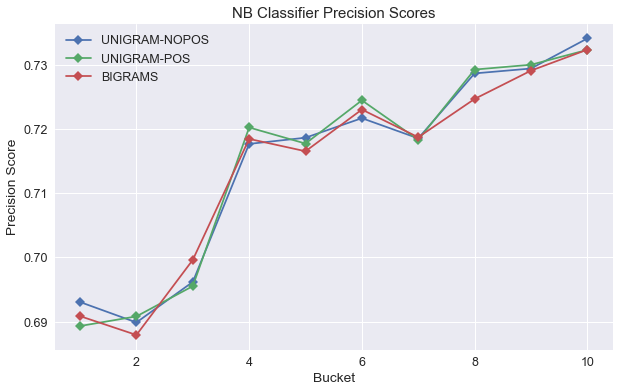

In [500]:
sns.set(font_scale=1.25)
plt.figure(figsize=(10,6))
plt.plot(range(1,11), nopos_precision_scores, marker='D', label='UNIGRAM-NOPOS')
plt.plot(range(1,11), pos_precision_scores, marker='D', label='UNIGRAM-POS')
plt.plot(range(1,11), bigrams_precision_scores, marker='D', label='BIGRAMS')
plt.title('NB Classifier Precision Scores')
plt.xlabel('Bucket')
plt.ylabel('Precision Score')
plt.legend()
plt.show()

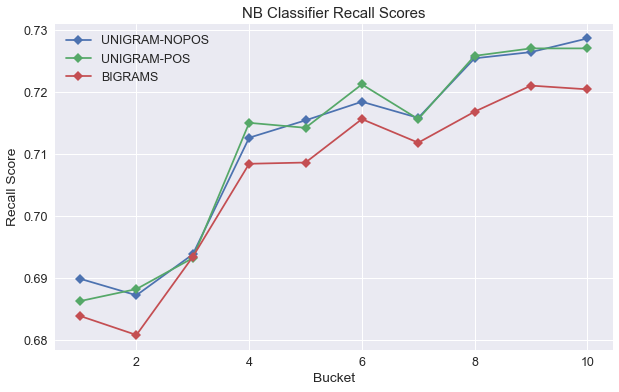

In [501]:
plt.figure(figsize=(10,6))
plt.plot(range(1,11), nopos_recall_scores, marker='D', label='UNIGRAM-NOPOS')
plt.plot(range(1,11), pos_recall_scores, marker='D', label='UNIGRAM-POS')
plt.plot(range(1,11), bigrams_recall_scores, marker='D', label='BIGRAMS')
plt.title('NB Classifier Recall Scores')
plt.xlabel('Bucket')
plt.ylabel('Recall Score')
plt.legend()
plt.show()

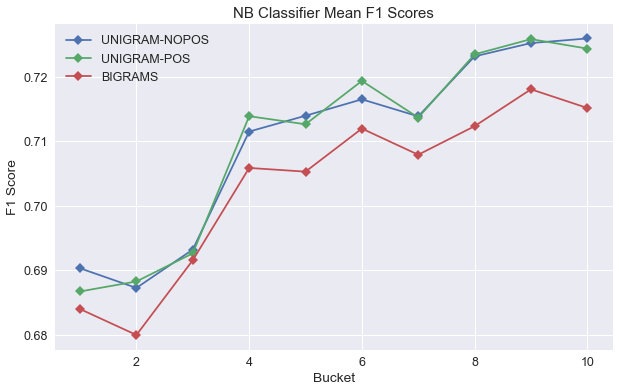

In [502]:
plt.figure(figsize=(10,6))
plt.plot(range(1,11), nopos_f1_scores, marker='D', label='UNIGRAM-NOPOS')
plt.plot(range(1,11), pos_f1_scores, marker='D', label='UNIGRAM-POS')
plt.plot(range(1,11), bigrams_f1_scores, marker='D', label='BIGRAMS')
plt.title('NB Classifier Mean F1 Scores')
plt.xlabel('Bucket')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

The unigram POS and unigram NOPOS classifiers have very similar performance across all buckets for all three metrics - it is clear that the extra information provided by the POS tags is not useful (partly because some of the tags are wrong). This was already foreshadowed by the Zipfian distributions in Part I.

Interestingly, the bigram classifier has a similar precision to the two unigram classifiers across all buckets, but it has a weaker recall and overall F1 score.

All three classifiers increase in accuracy as they go from short to long posts, although there are small dips at the second, fifth, and seventh buckets. There is also a small dip at the final bucket for precision and F1 scores for the unigram POS and bigram classifiers. The increase in accuracy is extremely similar for all three classifiers - it is the greatest by a very small margin for the unigram POS classifier, as demonstrated below.

In [845]:
print('Increase in F1 score for unigram NOPOS classifier:', max(nopos_f1_scores) - min(nopos_f1_scores))
print('Increase in F1 score for unigram POS classifier:', max(pos_f1_scores) - min(pos_f1_scores))
print('Increase in F1 score for bigram classifier:', max(bigrams_f1_scores) - min(bigrams_f1_scores))

Increase in F1 score for unigram NOPOS classifier: 0.03867665555320321
Increase in F1 score for unigram POS classifier: 0.03911957010221534
Increase in F1 score for bigram classifier: 0.038086790326598785


### Scikit-learn Implementation of NB Classifier with Smoothing Hack

For this specific dataset, we have verified that the following cheap hack will give you almost the same results as implementing your own smoother: after calculating the P_i of an OOV word for the male and female training sets, set alpha to the average of these probabilities. Repeat the same procedure to get different alphas for your unigram POS, unigram NOPOS, and bigram classifiers. These will all be extremely small numbers. Scikit will now be able to plow ahead and carry out the classification task. This is essentially an implementation of ‘add tiny’ smoothing. (We will discuss in class when this cheap hack might get you into trouble.)

In [106]:
sklearn_nopos_classifier = Pipeline([('vectorizer', DictVectorizer()),
                                     ('classifier', MultinomialNB(alpha=P_i_nopos))])

sklearn_nopos_classifier.fit([i[0] for i in nopos_training_set], [i[1] for i in nopos_training_set])

Pipeline(memory=None,
     steps=[('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('classifier', MultinomialNB(alpha=7.279920785036507e-08, class_prior=None, fit_prior=True))])

In [259]:
sklearn_pos_classifier = Pipeline([('vectorizer', DictVectorizer()),
                                   ('classifier', MultinomialNB(alpha=P_i_pos))])

sklearn_pos_classifier.fit([i[0] for i in pos_training_set], [i[1] for i in pos_training_set])

Pipeline(memory=None,
     steps=[('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('classifier', MultinomialNB(alpha=7.430114139651809e-08, class_prior=None, fit_prior=True))])

In [295]:
sklearn_bigrams_classifier = Pipeline([('vectorizer', DictVectorizer()),
                                       ('classifier', MultinomialNB(alpha=P_i_bigrams))])

sklearn_bigrams_classifier.fit([i[0] for i in bigrams_training_set], [i[1] for i in bigrams_training_set])

Pipeline(memory=None,
     steps=[('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('classifier', MultinomialNB(alpha=7.737739165888086e-08, class_prior=None, fit_prior=True))])

In [235]:
sklearn_nopos_precision_scores = []
sklearn_nopos_recall_scores = []
sklearn_nopos_f1_scores = []

for bucket in binned_nopos_test:
    sklearn_predicted_nopos = sklearn_nopos_classifier.predict([i[0] for i in bucket])
    sklearn_nopos_precision_scores.append(metrics.precision_score([i[1] for i in bucket], sklearn_predicted_nopos, average='weighted'))
    sklearn_nopos_recall_scores.append(metrics.recall_score([i[1] for i in bucket], sklearn_predicted_nopos, average='weighted'))
    sklearn_nopos_f1_scores.append(metrics.f1_score([i[1] for i in bucket], sklearn_predicted_nopos, average='weighted'))

In [260]:
sklearn_pos_precision_scores = []
sklearn_pos_recall_scores = []
sklearn_pos_f1_scores = []

for bucket in binned_pos_test:
    sklearn_predicted_pos = sklearn_pos_classifier.predict([i[0] for i in bucket])
    sklearn_pos_precision_scores.append(metrics.precision_score([i[1] for i in bucket], sklearn_predicted_pos, average='weighted'))
    sklearn_pos_recall_scores.append(metrics.recall_score([i[1] for i in bucket], sklearn_predicted_pos, average='weighted'))
    sklearn_pos_f1_scores.append(metrics.f1_score([i[1] for i in bucket], sklearn_predicted_pos, average='weighted'))

In [296]:
sklearn_bigrams_precision_scores = []
sklearn_bigrams_recall_scores = []
sklearn_bigrams_f1_scores = []

for bucket in binned_bigrams_test:
    sklearn_predicted_bigrams = sklearn_bigrams_classifier.predict([i[0] for i in bucket])
    sklearn_bigrams_precision_scores.append(metrics.precision_score([i[1] for i in bucket], sklearn_predicted_bigrams, average='weighted'))
    sklearn_bigrams_recall_scores.append(metrics.recall_score([i[1] for i in bucket], sklearn_predicted_bigrams, average='weighted'))
    sklearn_bigrams_f1_scores.append(metrics.f1_score([i[1] for i in bucket], sklearn_predicted_bigrams, average='weighted'))

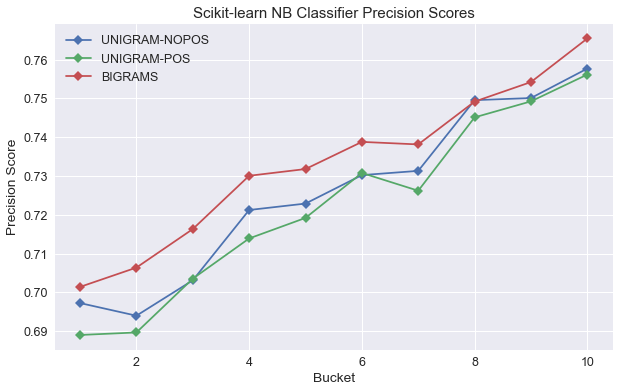

In [332]:
plt.figure(figsize=(10,6))
plt.plot(range(1,11), sklearn_nopos_precision_scores, marker='D', label='UNIGRAM-NOPOS')
plt.plot(range(1,11), sklearn_pos_precision_scores, marker='D', label='UNIGRAM-POS')
plt.plot(range(1,11), sklearn_bigrams_precision_scores, marker='D', label='BIGRAMS')
plt.title('Scikit-learn NB Classifier Precision Scores')
plt.xlabel('Bucket')
plt.ylabel('Precision Score')
plt.legend()
plt.show()

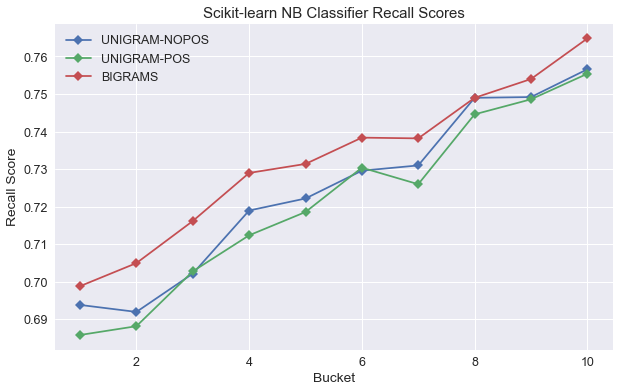

In [333]:
plt.figure(figsize=(10,6))
plt.plot(range(1,11), sklearn_nopos_recall_scores, marker='D', label='UNIGRAM-NOPOS')
plt.plot(range(1,11), sklearn_pos_recall_scores, marker='D', label='UNIGRAM-POS')
plt.plot(range(1,11), sklearn_bigrams_recall_scores, marker='D', label='BIGRAMS')
plt.title('Scikit-learn NB Classifier Recall Scores')
plt.xlabel('Bucket')
plt.ylabel('Recall Score')
plt.legend()
plt.show()

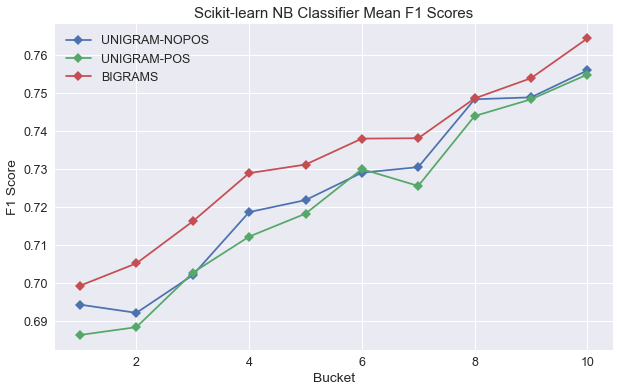

In [334]:
plt.figure(figsize=(10,6))
plt.plot(range(1,11), sklearn_nopos_f1_scores, marker='D', label='UNIGRAM-NOPOS')
plt.plot(range(1,11), sklearn_pos_f1_scores, marker='D', label='UNIGRAM-POS')
plt.plot(range(1,11), sklearn_bigrams_f1_scores, marker='D', label='BIGRAMS')
plt.title('Scikit-learn NB Classifier Mean F1 Scores')
plt.xlabel('Bucket')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

**Scikit-learn vs. Manual Implementation F1 Scores**

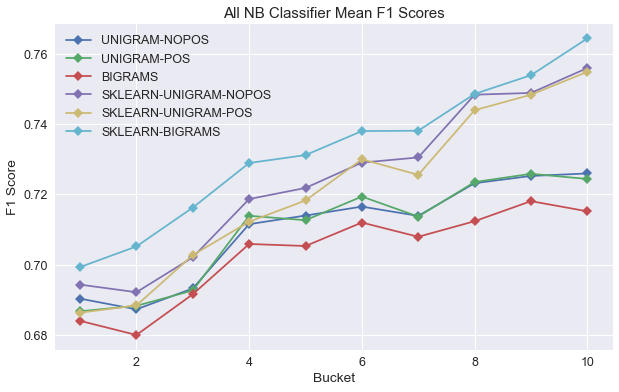

In [504]:
plt.figure(figsize=(10,6))
plt.plot(range(1,11), nopos_f1_scores, marker='D', label='UNIGRAM-NOPOS')
plt.plot(range(1,11), pos_f1_scores, marker='D', label='UNIGRAM-POS')
plt.plot(range(1,11), bigrams_f1_scores, marker='D', label='BIGRAMS')
plt.plot(range(1,11), sklearn_nopos_f1_scores, marker='D', label='SKLEARN-UNIGRAM-NOPOS')
plt.plot(range(1,11), sklearn_pos_f1_scores, marker='D', label='SKLEARN-UNIGRAM-POS')
plt.plot(range(1,11), sklearn_bigrams_f1_scores, marker='D', label='SKLEARN-BIGRAMS')
plt.title('All NB Classifier Mean F1 Scores')
plt.xlabel('Bucket')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

### NLTK Classifiers

The default smoothing estimator in NLTK's implementation of the Naïve Bayes classifier is Lidstone (the [`ELEProbDist`](https://www.nltk.org/_modules/nltk/probability.html) class), which is equivalent to an alpha value of 0.5. Accuracies are displayed for the entire test set (i.e., it is not divided into buckets), so this is not directly comparable with the above.

In [97]:
nltk_nopos_classifier = nltk.NaiveBayesClassifier.train(nopos_training_set)
print(nltk.classify.accuracy(nltk_nopos_classifier, nopos_test_set))
nltk_nopos_classifier.show_most_informative_features(10)

0.7063658726825464
Most Informative Features
                   Hubby = 1              female : male   =     43.8 : 1.0
                   hubby = 2              female : male   =     37.0 : 1.0
                knitting = 2              female : male   =     35.8 : 1.0
                    yarn = 2              female : male   =     29.0 : 1.0
                knitting = 3              female : male   =     26.3 : 1.0
                 crochet = 1              female : male   =     24.4 : 1.0
                   quilt = 2              female : male   =     23.7 : 1.0
                  duckie = 1              female : male   =     23.0 : 1.0
                     ate = 3              female : male   =     22.3 : 1.0
                   riffs = 1                male : female =     21.7 : 1.0


In [94]:
nltk_pos_classifier = nltk.NaiveBayesClassifier.train(pos_training_set)
print(nltk.classify.accuracy(nltk_pos_classifier, pos_test_set))
nltk_pos_classifier.show_most_informative_features(10)

0.7038659226815464
Most Informative Features
               Hubby/NNP = 1              female : male   =     44.2 : 1.0
            knitting/VBG = 2              female : male   =     42.3 : 1.0
                   ==/RB = 1                male : female =     35.7 : 1.0
              crochet/NN = 1              female : male   =     29.8 : 1.0
                 yarn/NN = 2              female : male   =     29.0 : 1.0
             Windows/NNP = 2                male : female =     28.3 : 1.0
                knit/VBN = 2              female : male   =     23.7 : 1.0
            Knitting/NNP = 1              female : male   =     23.0 : 1.0
               duckie/NN = 1              female : male   =     23.0 : 1.0
                 ate/VBD = 3              female : male   =     22.3 : 1.0


In [300]:
nltk_bigram_classifier = nltk.NaiveBayesClassifier.train(bigrams_training_set)
print(nltk.classify.accuracy(nltk_bigram_classifier, bigrams_test_set))
nltk_bigram_classifier.show_most_informative_features(10)

0.7013659726805463
Most Informative Features
         ('the', 'yarn') = 1              female : male   =     64.3 : 1.0
    ('decorate', 'your') = 1              female : male   =     39.7 : 1.0
        ('hubby', 'and') = 1              female : male   =     39.0 : 1.0
       ('knitting', ',') = 1              female : male   =     38.3 : 1.0
     ('All', 'graphics') = 1              female : male   =     36.3 : 1.0
         ('upkeep', '.') = 1              female : male   =     35.7 : 1.0
      ('samples', 'you') = 1              female : male   =     35.0 : 1.0
  ('distribute', 'them') = 1              female : male   =     35.0 : 1.0
   ('personal', 'craft') = 1              female : male   =     35.0 : 1.0
      ('All', 'current') = 1              female : male   =     35.0 : 1.0


### Part III: Relations of Classification to Burstiness and Sentiment Analysis

**Step 1**: Determine the words that occur in both the affect ratings dataset and the unigram NOPOS version of the blog post data (combine the training and test sets).

In [302]:
affect_df = pd.read_csv('BRM-emot-submit.csv', index_col=0)
print(affect_df.shape)
affect_df.head()

(13915, 64)


,Word,V.Mean.Sum,V.SD.Sum,V.Rat.Sum,A.Mean.Sum,A.SD.Sum,A.Rat.Sum,D.Mean.Sum,D.SD.Sum,D.Rat.Sum,...,A.Rat.L,A.Mean.H,A.SD.H,A.Rat.H,D.Mean.L,D.SD.L,D.Rat.L,D.Mean.H,D.SD.H,D.Rat.H
1,aardvark,6.26,2.21,19,2.41,1.40,22,4.27,1.75,15,...,11,2.55,1.29,11,4.12,1.64,8,4.43,1.99,7
2,abalone,5.30,1.59,20,2.65,1.90,20,4.95,1.79,22,...,12,2.38,1.92,8,5.55,2.21,11,4.36,1.03,11
3,abandon,2.84,1.54,19,3.73,2.43,22,3.32,2.50,22,...,11,3.82,2.14,11,2.77,2.09,13,4.11,2.93,9
4,abandonment,2.63,1.74,19,4.95,2.64,21,2.64,1.81,28,...,14,5.29,2.63,7,2.31,1.45,16,3.08,2.19,12
5,abbey,5.85,1.69,20,2.20,1.70,20,5.00,2.02,25,...,9,2.55,1.92,11,4.83,2.18,18,5.43,1.62,7


In [306]:
affect_wordlist = list(affect_df.Word)
affect_wordlist = [str(word) for word in affect_wordlist] # Need to convert into string as there are some floats.
print(len(affect_wordlist))
print(affect_wordlist[:5])

13915
['aardvark', 'abalone', 'abandon', 'abandonment', 'abbey']


In [312]:
unigram_nopos_vocab = list(female_training_nopos_vocab) + list(male_training_nopos_vocab) + list(test_nopos_vocab)
unigram_nopos_vocab = set(unigram_nopos_vocab)
len(unigram_nopos_vocab)

465770

In [318]:
affect_nopos_vocab = set(affect_wordlist).intersection(unigram_nopos_vocab)
affect_nopos_vocab = list(affect_nopos_vocab)
print(len(affect_nopos_vocab), 'words occur in both the affect ratings dataset and the unigram NOPOS dataset.')
print(affect_nopos_vocab[:10])

13739 words occur in both the affect ratings dataset and the unigram NOPOS dataset.
['cannabis', 'upright', 'sonic', 'ligament', 'prose', 'kettle', 'publish', 'lyrics', 'enthusiasm', 'sedate']


**Step 2**: From the intersection of the affect ratings dataset and the vocabulary of the unigram NOPOS version of the blogs, find the 500 ‘Warriner’ words that are most biased towards females, the 500 words that are most biased towards males, and the 500 words that are most neutral (e.g., closest to exactly the same usage by both genders). The function you created to return probability estimates for the features given a class label can be used to determine the gender bias of the words. In scikit-learn’s implementation of Naïve Bayes, the feature_log_prob_ attribute allows you to determine which words are most biased
towards each gender.

*Note*: There are words in the male training dataset that are not in the female training dataset or the test dataset. There are also words in the female training dataset that are not in the male training dataset or the test dataset. To make things easier, we will ignore these.

In [541]:
missing_words_female = []
missing_words_male = []

for word in affect_nopos_vocab:
    if word not in P_female_nopos:
        missing_words_female.append(word)
    if word not in P_male_nopos:
        missing_words_male.append(word)

In [540]:
print(len(missing_words_female), 'words are in the male training dataset but not in the female training or test datasets.')
print(missing_words_female)
print(len(missing_words_male), 'words are in the female training dataset but not in the male training or test datasets.')
print(missing_words_male)

89 words are in the male training dataset but not in the female training or test datasets.
['microfilm', 'gunfighter', 'accelerant', 'sidearm', 'stockholder', 'annulment', 'detonator', 'pheromone', 'correctional', 'assemblyman', 'senor', 'bagman', 'wolverine', 'bootlegger', 'courtside', 'brig', 'proctologist', 'hematoma', 'decryption', 'plainclothes', 'irrigate', 'bondsman', 'knighthood', 'skijump', 'scrambler', 'requisition', 'clod', 'ghoul', 'transference', 'lockup', 'archduke', 'satyr', 'prig', 'horseman', 'sidewinder', 'summerhouse', 'fuselage', 'tracer', 'pulsar', 'huckleberry', 'unquote', 'duchess', 'whelp', 'halfback', 'powwow', 'subspace', 'wienie', 'sainted', 'snowplow', 'succubus', 'isotope', 'airspeed', 'blackface', 'benzene', 'huntress', 'baroness', 'swordplay', 'matchbook', 'arsonist', 'coachman', 'musket', 'rubdown', 'hertz', 'bellman', 'jockstrap', 'downfield', 'lancer', 'woodsman', 'flagstaff', 'fatherland', 'flamethrower', 'nincompoop', 'cutlass', 'policewoman', 'invul

In [545]:
affect_nopos_vocab = [word for word in affect_nopos_vocab if word not in missing_words_female and word not in missing_words_male]

In [566]:
intersection_df = pd.DataFrame(affect_nopos_vocab, columns=['Word'])
intersection_df['P_male'] = intersection_df.apply(lambda row: P_male_nopos[row['Word']], axis=1)
intersection_df['P_female'] = intersection_df.apply(lambda row: P_female_nopos[row['Word']], axis=1)
intersection_df['P_diff'] = intersection_df['P_male'] - intersection_df['P_female']
intersection_df['P_diff_abs'] = abs(intersection_df['P_diff'])
intersection_df['N_male'] = intersection_df.apply(lambda row: male_nopos_counts[row['Word']] if row['Word'] in male_nopos_counts else 0, axis=1)
intersection_df['N_female'] = intersection_df.apply(lambda row: female_nopos_counts[row['Word']] if row['Word'] in female_nopos_counts else 0, axis=1)
intersection_df['N_total'] = intersection_df['N_male'] + intersection_df['N_female']
intersection_df.head()

,Word,P_male,P_female,P_diff,P_diff_abs,N_male,N_female,N_total
0,cannabis,2.203280e-07,2.120273e-07,8.300760e-09,8.300760e-09,3,3,6
1,upright,4.186233e-06,4.593924e-06,-4.076916e-07,4.076916e-07,57,65,122
2,sonic,2.570494e-06,9.187849e-07,1.651709e-06,1.651709e-06,35,13,48
3,ligament,4.406561e-07,5.654061e-07,-1.247500e-07,1.247500e-07,6,8,14
4,prose,5.581644e-06,3.957843e-06,1.623801e-06,1.623801e-06,76,56,132


In [790]:
most_female = list(intersection_df.nsmallest(500, 'P_diff').Word)
most_male = list(intersection_df.nlargest(500, 'P_diff').Word)
most_neutral = list(intersection_df.nsmallest(500, 'P_diff_abs').Word)

print('10 Warriner words with female bias:', most_female[:10])
print('10 Warriner words with male bias:', most_male[:10])
print('10 Warriner words that are neutral:', most_neutral[:10])

10 Warriner words with female bias: ['have', 'know', 'love', 'like', 'go', 'get', 'do', 'want', 'think', 'little']
10 Warriner words with male bias: ['world', 'game', 'com', 'government', 'war', 'team', 'people', 'site', 'man', 'will']
10 Warriner words that are neutral: ['muster', 'sweep', 'preoccupied', 'venom', 'iceberg', 'distressed', 'barren', 'heartless', 'erratic', 'trivia']


The summary statistics for the `N_total` columns of the dataframes of the most biased and most neutral words reveal that the biased words occur with far greater frequency than the neutral words. This creates problematic floor effects - our current set of neutral words is dominated by words that were only used in a small handful of blog posts, and thus have extremely low dispersion that does not provide us with enough statistical power.

To account for the floor effects, we need to generate a second set of most neutral words that are frequency-matched with the gender biased words. The minimum frequency for female-biased words is 214; the minimum for male-biased words is 254. 214 should also be our minimum frequency for the neutral words.

In [791]:
display(intersection_df.nsmallest(500, 'P_diff')['N_total'].describe())
display(intersection_df.nlargest(500, 'P_diff')['N_total'].describe())
display(intersection_df.nsmallest(500, 'P_diff_abs')['N_total'].describe())

count       500.000000
mean       5481.796000
std       12084.287073
min         214.000000
25%         862.250000
50%        1973.500000
75%        5121.500000
max      136699.000000
Name: N_total, dtype: float64

count      500.000000
mean      2560.418000
std       4626.627003
min        254.000000
25%        835.500000
50%       1436.500000
75%       2512.250000
max      68892.000000
Name: N_total, dtype: float64

count     500.000000
mean       21.694000
std       159.825156
min         0.000000
25%         1.000000
50%         4.000000
75%         8.000000
max      3487.000000
Name: N_total, dtype: float64

In [805]:
intersection_df_minfreq = intersection_df[intersection_df['N_total'] >= 214]
most_neutral_minfreq = list(intersection_df_minfreq.nsmallest(500, 'P_diff_abs').Word)
print('10 Warriner words that are neutral and occur at least 214 times:', most_neutral_minfreq[:10])

10 Warriner words that are neutral and occur at least 214 times: ['stand', 'react', 'gallery', 'luxury', 'harmony', 'meaningful', 'soil', 'independence', 'stone', 'bowling']


We can see that the absolute value of the `P_diff_abs` column (our measure of neutrality) is still very low for these more frequent words.

In [814]:
display(intersection_df.sort_values(by=['P_diff_abs']).head(5))
display(intersection_df_minfreq.sort_values(by=['P_diff_abs']).head(5))

,Word,P_male,P_female,P_diff,P_diff_abs,N_male,N_female,N_total
4824,muster,0.000004,0.000004,-2.385950e-10,2.385950e-10,51,53,104
6390,sweep,0.000006,0.000006,1.025568e-09,1.025568e-09,77,80,157
2477,preoccupied,0.000002,0.000002,1.264163e-09,1.264163e-09,26,27,53
8987,distressed,0.000002,0.000002,1.264163e-09,1.264163e-09,26,27,53
8346,iceberg,0.000002,0.000002,1.264163e-09,1.264163e-09,26,27,53


,Word,P_male,P_female,P_diff,P_diff_abs,N_male,N_female,N_total
8239,stand,0.000126,0.000126,-3.842551e-09,3.842551e-09,1710,1777,3487
9951,react,0.000011,0.000011,-9.016545e-09,9.016545e-09,150,156,306
10776,gallery,0.000015,0.000015,-1.202206e-08,1.202206e-08,200,208,408
7491,luxury,0.000010,0.000010,2.015541e-08,2.015541e-08,135,140,275
10447,harmony,0.000008,0.000008,2.165817e-08,2.165817e-08,110,114,224


**Step 3**: To operationalize Hypothesis I, calculate $D^{U}$ for all of your target words. Since we have no user IDs for the bloggers, note that each blog posting has to be viewed as a independent document, so we are really talking about a $D^{B}$ measure that is analogous to the $D^{U}$ and $D^{T}$ measures in Altmann et al. The same math is valid and necessary because the blog posts vary considerably in length.

Critical formula: $D^{U}$ = $U_w$/${\tilde{U}_w}$

First we need to compute $U_w$, the number of users who used the word at least once. This is equivalent to the number of blog posts in which the word appears in the combined NOPOS training and test datasets. For efficiency, we will use the dictionary of word counts for each blog post as opposed to the list of words in each blog post.

In [667]:
nopos_posts = nopos_training_set + nopos_test_set # This is a list of tuples: the first element is the dictionary of word counts; the second is the label.

def getU_w(word):
    U_w = 0
    for post in nopos_posts: 
        if word in post[0].keys(): # We are only interested in the first element of the tuple.
            U_w += 1
    return U_w

In [815]:
female_bias_df = pd.DataFrame(most_female, columns=['Word'])
female_bias_df['U_w'] = female_bias_df.apply(lambda row: getU_w(row['Word']), axis=1)
male_bias_df = pd.DataFrame(most_male, columns=['Word'])
male_bias_df['U_w'] = male_bias_df.apply(lambda row: getU_w(row['Word']), axis=1)
neutral_df = pd.DataFrame(most_neutral, columns=['Word'])
neutral_df['U_w'] = neutral_df.apply(lambda row: getU_w(row['Word']), axis=1)
neutral_minfreq_df = pd.DataFrame(most_neutral_minfreq, columns=['Word'])
neutral_minfreq_df['U_w'] = neutral_minfreq_df.apply(lambda row: getU_w(row['Word']), axis=1)

Next we need to compute ${\tilde{U}_w}$, the number of users who would be expected to use the word at least once under the Naïve Bag of Words model - i.e., if all of the words in the dataset are shuffled randomly, preserving the total contribution of each user (represented by the size of each blog post). This is calculated as the complement of the probability of using the word zero times.

Critical formula: $1-e^{-f_w m_i}$

$f_w$ is the frequency of the word expressed as a probability. This can be computed as the number of times the word occurs in the dataset / number of words in the dataset.

$m_i$ is the total number of words contributed by user $i$. This is the length of a blog post.

In [675]:
nopos_wordlist = female_training_nopos_wordlist + male_training_nopos_wordlist + test_nopos_wordlist
nopos_counts = Counter(nopos_wordlist) # Frequency count for each word in the dataset.
len(nopos_wordlist) # Number of words in the dataset.

41229691

In [680]:
def getf_w(word):
    return nopos_counts[word]/len(nopos_wordlist)

In [816]:
female_bias_df['f_w'] = female_bias_df.apply(lambda row: getf_w(row['Word']), axis=1)
male_bias_df['f_w'] = male_bias_df.apply(lambda row: getf_w(row['Word']), axis=1)
neutral_df['f_w'] = neutral_df.apply(lambda row: getf_w(row['Word']), axis=1)
neutral_minfreq_df['f_w'] = neutral_minfreq_df.apply(lambda row: getf_w(row['Word']), axis=1)

In [686]:
nopos_post_wordlist = female_test_nopos + male_test_nopos + female_training_nopos + male_training_nopos

In [692]:
def getE_w(f_w):
    E_w = 0
    for post in nopos_post_wordlist:
        E_w += (1 - np.exp(-f_w*len(post)))
    return E_w

In [817]:
female_bias_df['E_w'] = female_bias_df.apply(lambda row: getE_w(row['f_w']), axis=1)
male_bias_df['E_w'] = male_bias_df.apply(lambda row: getE_w(row['f_w']), axis=1)
neutral_df['E_w'] = neutral_df.apply(lambda row: getE_w(row['f_w']), axis=1)
neutral_minfreq_df['E_w'] = neutral_minfreq_df.apply(lambda row: getE_w(row['f_w']), axis=1)

In [818]:
female_bias_df['D_u'] = female_bias_df['U_w']/female_bias_df['E_w']
male_bias_df['D_u'] = male_bias_df['U_w']/male_bias_df['E_w']
neutral_df['D_u'] = neutral_df['U_w']/neutral_df['E_w']
neutral_minfreq_df['D_u'] = neutral_minfreq_df['U_w']/neutral_minfreq_df['E_w']

**Step 4**: To operationalize Hypothesis II, take the difference between the V.Mean.M and V.Mean.F fields of the affect ratings data. Be sure to keep track of the sign of the difference.

In [320]:
affect_df['V.Diff'] = affect_df['V.Mean.M'] - affect_df['V.Mean.F']

In [330]:
affect_df[['Word', 'V.Diff']].sort_values(by=['V.Diff']).head(10)

,Word,V.Diff
4555,femininity,-4.06
11009,share,-3.55
7849,mommy,-3.40
8432,openness,-3.40
2935,cross,-3.22
9179,plutonium,-3.20
13915,zucchini,-3.17
9564,prophet,-3.14
7518,maternal,-3.06
1416,boyfriend,-3.02


In [331]:
affect_df[['Word', 'V.Diff']].sort_values(by=['V.Diff'], ascending=False).head(10)

,Word,V.Diff
12518,threesome,4.48
4996,fuck,3.90
4998,fucking,3.87
2946,crowd,3.80
9719,pussy,3.64
1901,centerfold,3.48
12098,supermodel,3.43
11060,shitfaced,3.40
1855,cathouse,3.37
6026,hustler,3.31


In [819]:
female_bias_df = pd.merge(female_bias_df, affect_df[['Word', 'V.Diff']], on='Word')
male_bias_df = pd.merge(male_bias_df, affect_df[['Word', 'V.Diff']], on='Word')
neutral_df = pd.merge(neutral_df, affect_df[['Word', 'V.Diff']], on='Word')
neutral_minfreq_df = pd.merge(neutral_minfreq_df, affect_df[['Word', 'V.Diff']], on='Word')

In [820]:
display(female_bias_df.head(), male_bias_df.head(), neutral_df.head(), neutral_minfreq_df.head())

,Word,U_w,f_w,E_w,D_u,V.Diff
0,have,85418,0.004973,95411.041276,0.895263,-2.14
1,know,44150,0.001765,52392.470896,0.842678,0.10
2,love,22950,0.000947,32401.555969,0.708299,-0.83
3,like,57764,0.002511,66302.019425,0.871225,-1.70
4,go,36465,0.001312,42045.543556,0.867274,-0.40


,Word,U_w,f_w,E_w,D_u,V.Diff
0,world,17307,0.000591,21614.064944,0.800729,0.44
1,game,6028,0.000253,9913.076825,0.608086,-0.55
2,com,8127,0.000298,11553.564404,0.703419,0.83
3,government,3286,0.000126,5071.619404,0.647919,0.62
4,war,3711,0.000149,5953.442897,0.623337,0.69


,Word,U_w,f_w,E_w,D_u,V.Diff
0,muster,153,0.000004,155.875820,0.981551,-0.59
1,sweep,215,0.000006,237.711063,0.904459,0.28
2,preoccupied,88,0.000002,89.958656,0.978227,-1.36
3,venom,67,0.000002,78.968143,0.848443,-0.60
4,iceberg,59,0.000002,67.976396,0.867948,0.93


,Word,U_w,f_w,E_w,D_u,V.Diff
0,stand,4482,0.000126,5052.645946,0.887060,-0.16
1,react,414,0.000011,446.977154,0.926222,1.10
2,gallery,483,0.000014,592.202980,0.815599,-0.22
3,luxury,391,0.000010,408.147344,0.957987,1.27
4,harmony,278,0.000008,331.437985,0.838769,-1.31


**QUESTION 4**: Visually represent the relationships amongst your results from Steps 2, 3, and 4 and explain what you see. Which hypotheses are supported? (Note that no statistical correlations can be computed here, so this setup cannot provide any firm conclusions.)
- Hypothesis I: Men and women tend to have interests and expertise in different topics. The words that characterise a topic are used repeatedly when talking about that topic, and seldom elsewhere. Therefore, the most biased words should coincide with the most bursty words.
- Hypothesis II: Women create social bonds by talking about things that they like more than men do. Men do the same thing. Therefore, the most biased words should be the ones that have the greatest distance in emotional valency between men and women. For example, *blast* is rated with more positive valency by men than by women, so this hypothesis predicts that men should talk more about blasts.
- Hypothesis III: Both are true. These factors are so highly correlated that you can’t really distinguish them.

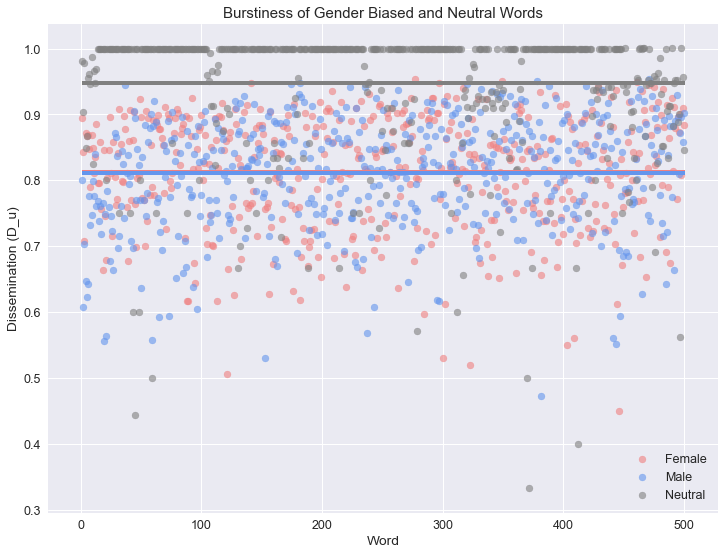

In [835]:
plt.figure(figsize=(12,9))
plt.scatter(range(1,501), female_bias_df['D_u'], label='Female', color='lightcoral', alpha=0.6)
plt.scatter(range(1,501), male_bias_df['D_u'], label='Male', color='cornflowerblue', alpha=0.6)
plt.scatter(range(1,501), neutral_df['D_u'], label='Neutral', color='grey', alpha=0.6)
plt.hlines(np.mean(female_bias_df['D_u']), 1, 501, color='lightcoral', linewidth=4)
plt.hlines(np.mean(male_bias_df['D_u']), 1, 501, color='cornflowerblue', linewidth=4)
plt.hlines(np.mean(neutral_df['D_u']), 1, 501, color='grey', linewidth=4)
plt.title('Burstiness of Gender Biased and Neutral Words')
plt.xlabel('Word')
plt.ylabel('Dissemination (D_u)')
plt.legend(loc='lower right')
plt.show()

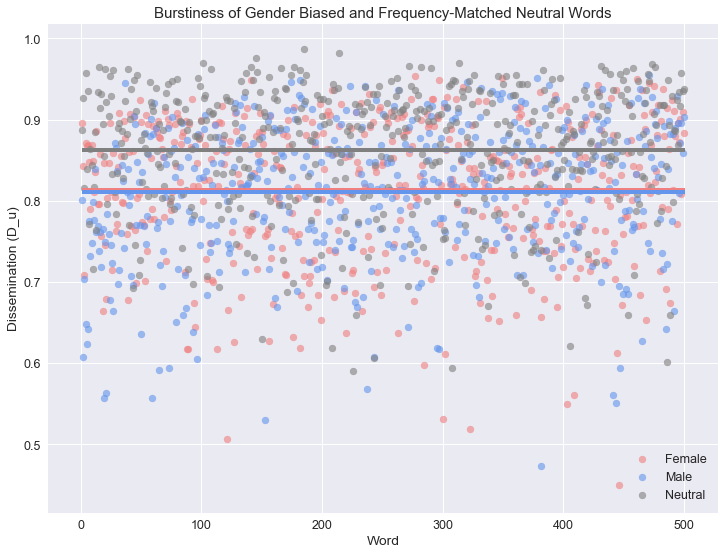

In [832]:
plt.figure(figsize=(12,9))
plt.scatter(range(1,501), female_bias_df['D_u'], label='Female', color='lightcoral', alpha=0.6)
plt.scatter(range(1,501), male_bias_df['D_u'], label='Male', color='cornflowerblue', alpha=0.6)
plt.scatter(range(1,501), neutral_minfreq_df['D_u'], label='Neutral', color='grey', alpha=0.6)
plt.hlines(np.mean(female_bias_df['D_u']), 1, 501, color='lightcoral', linewidth=4)
plt.hlines(np.mean(male_bias_df['D_u']), 1, 501, color='cornflowerblue', linewidth=4)
plt.hlines(np.mean(neutral_minfreq_df['D_u']), 1, 501, color='grey', linewidth=4)
plt.title('Burstiness of Gender Biased and Frequency-Matched Neutral Words')
plt.xlabel('Word')
plt.ylabel('Dissemination (D_u)')
plt.legend(loc='lower right')
plt.show()

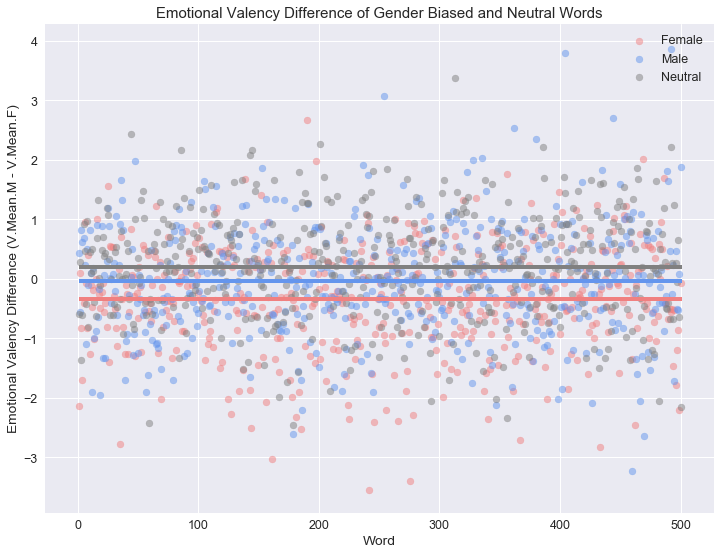

In [836]:
plt.figure(figsize=(12,9))
plt.scatter(range(1,501), female_bias_df['V.Diff'], label='Female', color='lightcoral', alpha=0.5)
plt.scatter(range(1,501), male_bias_df['V.Diff'], label='Male', color='cornflowerblue', alpha=0.5)
plt.scatter(range(1,501), neutral_df['V.Diff'], label='Neutral', color='grey', alpha=0.5)
plt.hlines(np.mean(female_bias_df['V.Diff']), 1, 501, color='lightcoral', linewidth=4)
plt.hlines(np.mean(male_bias_df['V.Diff']), 1, 501, color='cornflowerblue', linewidth=4)
plt.hlines(np.mean(neutral_df['V.Diff']), 1, 501, color='grey', linewidth=4)
plt.title('Emotional Valency Difference of Gender Biased and Neutral Words')
plt.xlabel('Word')
plt.ylabel('Emotional Valency Difference (V.Mean.M - V.Mean.F)')
plt.legend(loc='upper right')
plt.show()

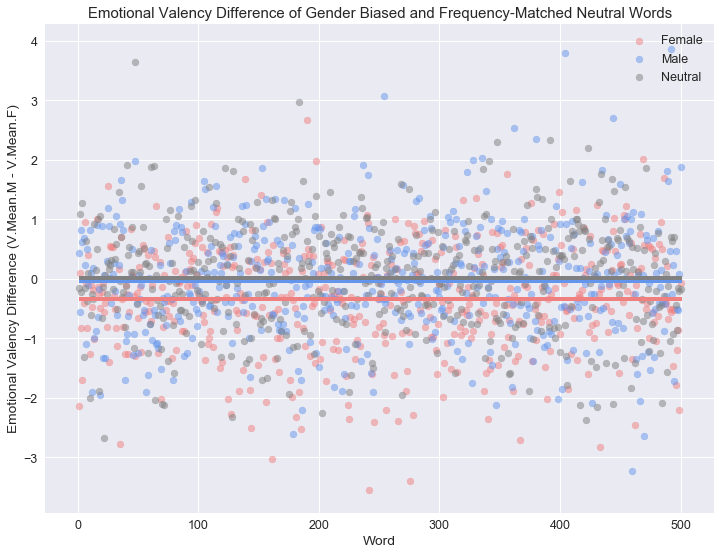

In [837]:
plt.figure(figsize=(12,9))
plt.scatter(range(1,501), female_bias_df['V.Diff'], label='Female', color='lightcoral', alpha=0.5)
plt.scatter(range(1,501), male_bias_df['V.Diff'], label='Male', color='cornflowerblue', alpha=0.5)
plt.scatter(range(1,501), neutral_minfreq_df['V.Diff'], label='Neutral', color='grey', alpha=0.5)
plt.hlines(np.mean(female_bias_df['V.Diff']), 1, 501, color='lightcoral', linewidth=4)
plt.hlines(np.mean(male_bias_df['V.Diff']), 1, 501, color='cornflowerblue', linewidth=4)
plt.hlines(np.mean(neutral_minfreq_df['V.Diff']), 1, 501, color='grey', linewidth=4)
plt.title('Emotional Valency Difference of Gender Biased and Frequency-Matched Neutral Words')
plt.xlabel('Word')
plt.ylabel('Emotional Valency Difference (V.Mean.M - V.Mean.F)')
plt.legend(loc='upper right')
plt.show()

Hypothesis I is supported: the gender biased words have a lower dissemination measure ($D^{U}$) than the neutral words. $D^{U}$ is 1.0 if the word is actually randomly distributed. The value is smaller if the word is concentrated (i.e., more bursty). It is bigger if the word is more evenly distributed than the Naïve Bag of Words model predicts. The difference in burstiness between the gender biased words and the neutral words is less pronounced when the neutral words are frequency-matched.

Hypothesis II is not supported. The difference in emotional valency for men and women of the most biased words is very similar to the difference in emotional valency of the most neutral words. Once again, this difference is even less pronounced when the neutral words are frequency-matched.

### Lexical Dispersion Plots with NLTK

Just for fun, we can visualise the burstiness of words using NLTK's lexical dispersion plots. Before we can apply the function, we need to transform our tokenised and concatenated blog posts into NLTK Text objects. Let's compare a neutral word ('the'), a female biased word ('love'), and a male biased word ('war').

In [861]:
female_training_nopos_corpus = nltk.Text(female_training_nopos_wordlist)
male_training_nopos_corpus = nltk.Text(male_training_nopos_wordlist)

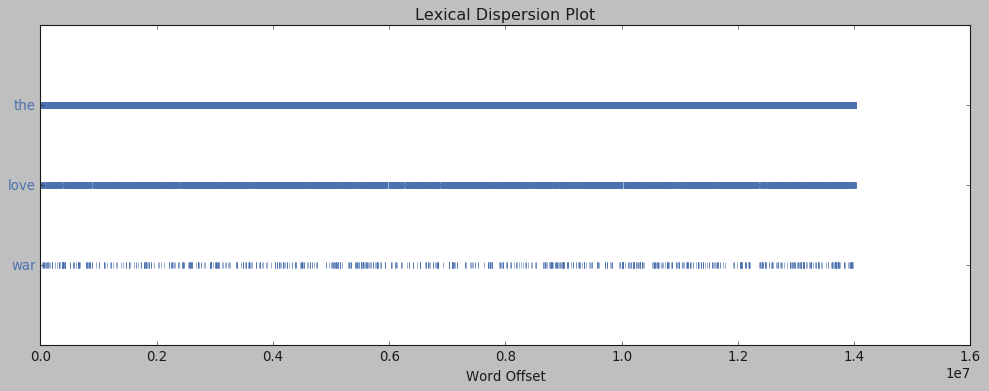

In [859]:
plt.style.use('classic')
plt.figure(figsize=(15, 5)) 
female_training_nopos_corpus.dispersion_plot(['the', 'love', 'war'])

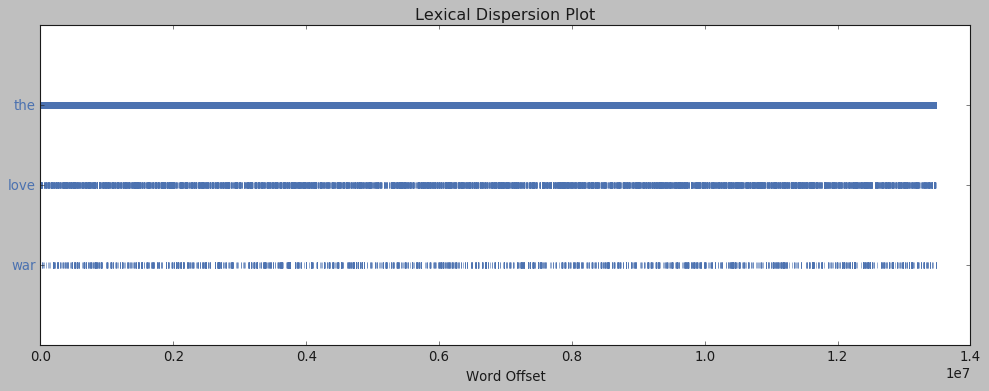

In [862]:
plt.figure(figsize=(15, 5)) 
male_training_nopos_corpus.dispersion_plot(['the', 'love', 'war'])